<a href="https://colab.research.google.com/github/james-hughes1/wdss-nlp-project/blob/main/Exploratory_Analysis_COP24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preamble

In [1]:
# Import libraries
# Data Processing
import pandas as pd
import numpy as np
import re
import datetime as dt
import random

# Statistical Modelling
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Files
import os
import zipfile

In [2]:
# Function to make colormap of scatter plots uniform

def scatter_cmap(colours):
    colours_unique = list(set(colours))
    colours_unique.sort()
    n = len(colours_unique)
    colours_scaled = []
    for c in colours:
        colours_scaled.append(colours_unique.index(c)/n)
    return colours_unique, colours_scaled


In [3]:
# Download the GloVe embedding data
# This may take upto 3 minutes

!wget --no-check-certificate \
     http://nlp.stanford.edu/data/glove.6B.zip \
     -O /tmp/glove.6B.zip

--2023-01-30 12:28:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-30 12:28:13--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-30 12:28:13--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’


In [3]:
# Read and format the twitter scrape .csv file
# Add the .csv file to the workspace or this won't work

dateparse = lambda dates: [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in dates]

tweets_df = pd.read_csv("Twitter Scrape 4_Reduced.csv", usecols=['ID', 'Date', 'Likes', 'Replies', 'Retweets', 'User ID', 'Username', 
                                                                 'Followers', 'Verified', 'Content', 'Time', 'Category'],
                        date_parser = dateparse, parse_dates=["Date"], encoding="UTF-8")
tweets_df["Time"] = pd.to_datetime(tweets_df["Time"], format='%H:%M:%S').dt.time
tweets_df["Date"] = pd.to_datetime(tweets_df["Date"], format='%H:%M:%S').dt.date

In [4]:
# Dendogram plotting function

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(18,16))
    plt.title("Hierarchical Clustering Dendrogram")
    dendrogram(linkage_matrix, **kwargs)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()

In [5]:
# Extract GloVe embedding data

with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

embeddings_index = {}
f = open('/tmp/glove/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


## Text Pre-Processing

In [6]:
# Use regex to clean tweets
tweets_clean = []

for i in range(len(tweets_df)):
    tweet_raw = tweets_df["Content"][i]
    tweet_edit_1 = re.sub("http\S+", "", tweet_raw.lower())
    tweet_edit_2 = re.sub("&amp;", "and", tweet_edit_1)
    tweet_edit_3 = re.sub(r"[^@#%$£\w\⁠s,. ]", "", tweet_edit_2) # Filter emojis
    tweet_edit_4 = re.sub("[.,:;'\"] | [.,:;'\"]", " ", tweet_edit_3)
    tweets_clean.append(tweet_edit_4.strip())

In [7]:
# Sample cleaned tweets

tweets_clean[0]

'met with costa rican environment minister carlos manuel rodríguez on the margins of #unbiodiversityconference #cop14 discussed importance of finalizing #parisagreement implementation guidelines at @unfccc #cop24 praised costa rica for its ambtious #carbonneutrality plans'

In [8]:
# Preprocessing hyperparameters

vocab_size = 20000
max_length = 24

# Tokenize text data

tokenizer = Tokenizer(oov_token="<OOV>",
                    num_words=vocab_size,
                    filters="")
tokenizer.fit_on_texts(tweets_clean)

In [9]:
# Construct word frequency dataframe

freq_analysis_df = pd.DataFrame(data = dict(tokenizer.word_counts).items(),
                                columns = ["Word", "Count"]).sort_values(by="Count",ascending=False)

In [10]:
# Build embedding_matrix

word_index = list(freq_analysis_df["Word"])
embedding_matrix = np.zeros((len(word_index), 100))
for i, word in enumerate(word_index):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

### Stop Words

In [11]:
nltk.download("stopwords")
stop_words = list(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
print("Fraction stop words: ", np.sum(freq_analysis_df[freq_analysis_df["Word"].isin(stop_words)]["Count"])/np.sum(freq_analysis_df["Count"]))

Fraction stop words:  0.36436058700209645


In [13]:
freq_analysis_df[freq_analysis_df["Count"]==1]

,Word,Count
9557,@secretaryzinke,1
7523,greeting,1
9556,interior,1
9555,@sierraclub,1
8986,potentially,1
...,...,...
5467,@tveinspire,1
5466,@gef_sgp,1
5464,artur,1
5462,zaheer,1


## Lexicon-Level Analysis

In [14]:
# Word Frequencies

freq_analysis_df.head(50)

,Word,Count
10,the,5138
66,to,3545
23,#cop24,2869
34,and,2464
12,of,2058
21,at,1690
42,in,1573
47,a,1491
56,climate,1301
26,for,1270


###Clustering

In [15]:
# Construct non-zero embedding matrix and assign cluster zero

freq_analysis_df["Cluster"] = -1
embeddings = []
valid_word_index = []
for i, row in enumerate(embedding_matrix):
    if (row==0).all():
        freq_analysis_df.iloc[i,2] = 0
    else:
        valid_word_index.append(i)
        embeddings.append(row)
embedding_matrix_nz = np.array(embeddings)

In [16]:
# Number of words not included in GloVe model

count1 = 0
count2 = 0
for row in freq_analysis_df[freq_analysis_df["Cluster"]==0]["Word"]:
  if "#" in row:
    count1+=1
  if "@" in row:
    count2+=1
print("Number of words unknown to GloVe: ", len(freq_analysis_df[freq_analysis_df["Cluster"]==0]))
print("Number of unique hashtags: ", count1)
print("Number of unique user @'s: ", count2)

Number of words unknown to GloVe:  3484
Number of unique hashtags:  1105
Number of unique user @'s:  1171


In [17]:
# Agglomerative Clustering (to produce dendrogram, not for actual cluster assignments)

num_clusters_words = 50
clustering_agg_words = AgglomerativeClustering(n_clusters=None, distance_threshold=0.1,
                                               affinity="cosine", linkage="average").fit(normalize(embedding_matrix_nz, axis=1))

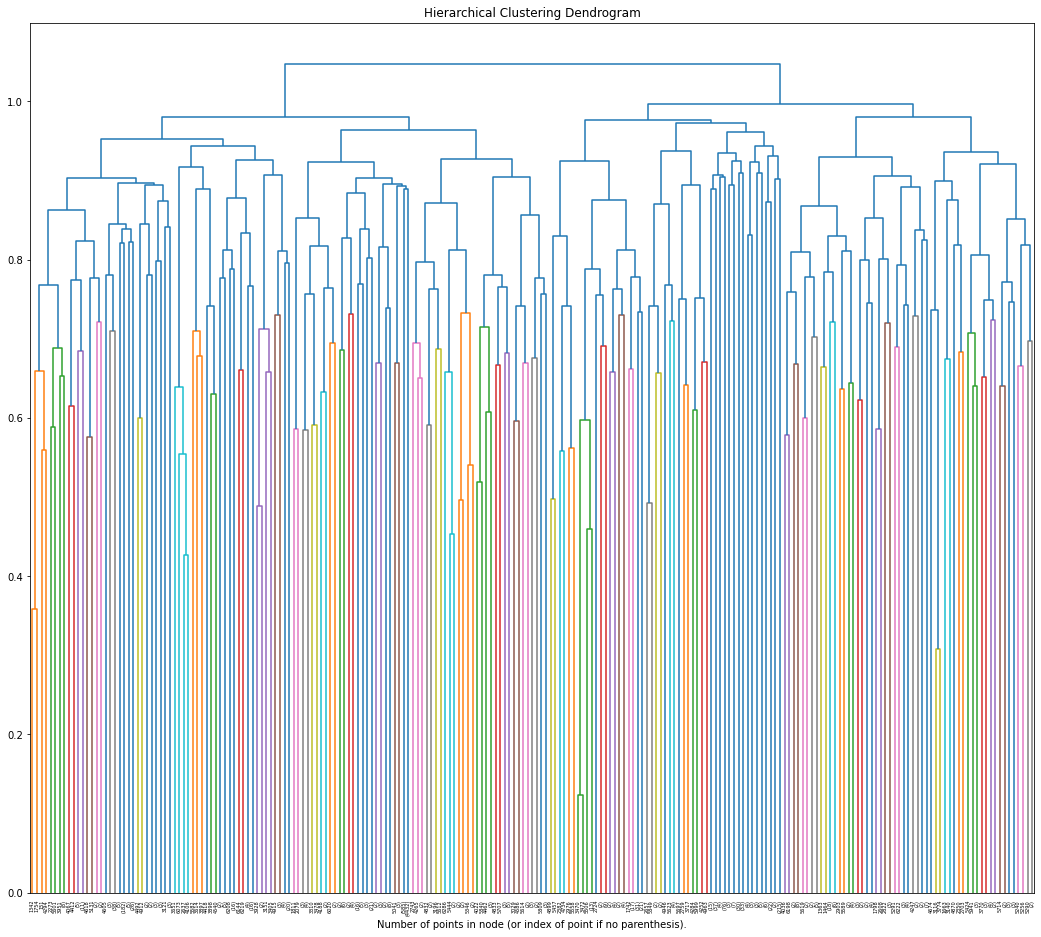

In [18]:
# Plot Dendrogram
# This cell only functions if n_clusters is not specified in the agglomerative clustering

plot_dendrogram(clustering_agg_words, truncate_mode="level", p=7)

In [19]:
# K-Means Clustering

num_clusters_words = 50
# L2 normalising the embeddings makes K-means euclidean clustering the same as K-means cosine similarity clustering
kmeans_words = KMeans(n_clusters=num_clusters_words-1, random_state=0, n_init=10).fit(normalize(embedding_matrix_nz, axis=1))
for i in range(len(valid_word_index)):
    # We reserve zero for words that don't belong to the GloVe model.
    freq_analysis_df.iloc[valid_word_index[i],2] = kmeans_words.labels_[i]+1

In [20]:
# Display Cluster Information

for k in range(num_clusters_words):
  print("\nCluster: ",k)
  cluster_df = freq_analysis_df[freq_analysis_df["Cluster"]==k]
  print(len(cluster_df)/len(freq_analysis_df))
  print("Average Word Count: ", np.mean(cluster_df["Count"]))
  print(freq_analysis_df[freq_analysis_df["Cluster"]==k].iloc[:30])


Cluster:  0
0.3562007974644719
Average Word Count:  4.315154994259472
                      Word  Count  Cluster
23                  #cop24   2869        0
101         #climateaction    689        0
681                  cop24    570        0
32          #climatechange    476        0
208               #climate    297        0
18         #parisagreement    295        0
217                 @cop24    139        0
119                    @un    130        0
22                 @unfccc    127        0
2960             #mdbtalks    123        0
257      #talanoa4ambition    117        0
1943           #wwfclimate    112        0
353          #takeyourseat     89        0
139              #katowice     88        0
387            #stepup2018     83        0
1792            @worldbank     78        0
1425      @antonioguterres     73        0
70                    1.5c     70        0
1895    #adaptationmatters     67        0
894         @gretathunberg     67        0
2239             #pandahub

In [21]:
# More detail about a specific cluster

freq_analysis_df[freq_analysis_df["Cluster"]==26].head(50)

,Word,Count,Cluster
1062,hub,42,26
158,air,35,26
1766,transport,30,26
1912,launch,26,26
3713,vehicles,23,26
1896,launching,14,26
179,driving,14,26
1152,ramp,13,26
2371,train,12,26
2751,powered,10,26


### PCA Visualisation of Lexicon Clusters

In [22]:
# Compute first three principal components of word embedding data

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
embedding_matrix_pc = pca.fit_transform(embedding_matrix)
freq_analysis_df["PC1"] = embedding_matrix_pc[:,0]
freq_analysis_df["PC2"] = embedding_matrix_pc[:,1]
freq_analysis_df["PC3"] = embedding_matrix_pc[:,2]

In [23]:
pca.explained_variance_ratio_

array([0.13975477, 0.04460236, 0.03663856])

In [24]:
# Filter dataframe for plotting

freq_analysis_df_filtered = freq_analysis_df[freq_analysis_df["Cluster"].isin([2,3,20,36,45]) & (freq_analysis_df["Count"]>0)]

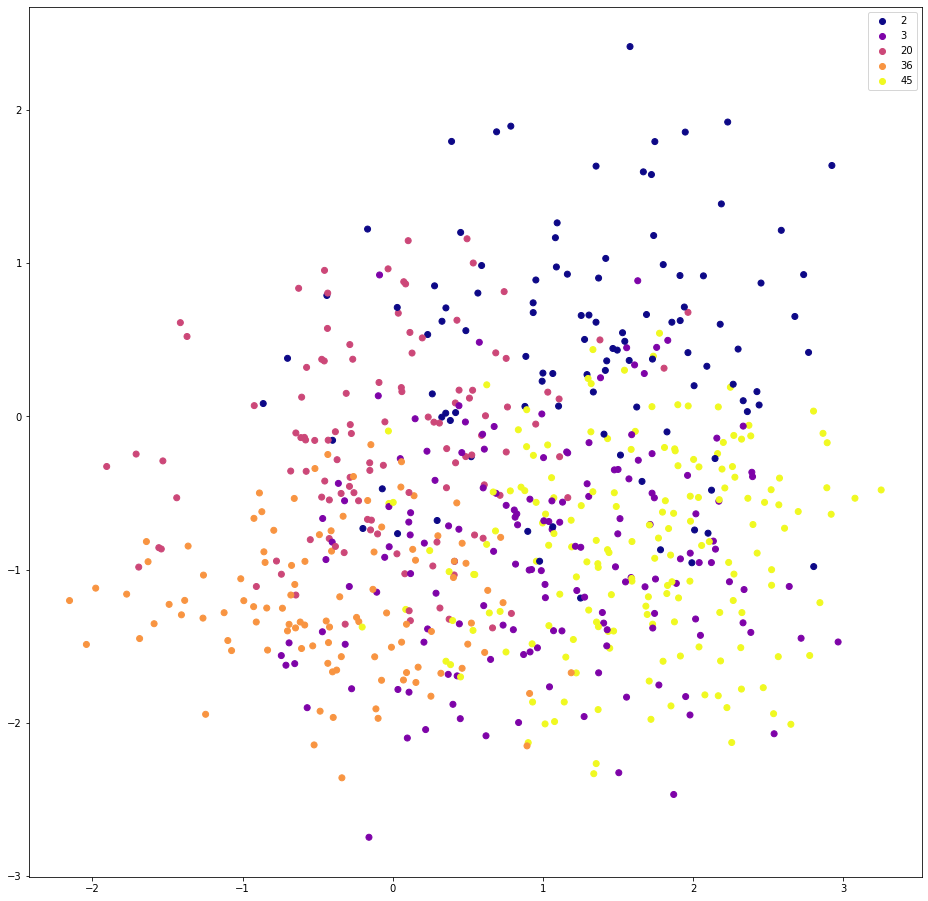

In [25]:
# 2D PC Plot

colours_unique, colours_scaled = scatter_cmap(list(freq_analysis_df_filtered["Cluster"]))

plt.figure(figsize=(16,16))
scatter = plt.scatter(freq_analysis_df_filtered["PC1"],
            freq_analysis_df_filtered["PC2"],
            c=colours_scaled,
            cmap = "plasma")
handles, labels = scatter.legend_elements()
plt.legend(handles, colours_unique)
plt.show()

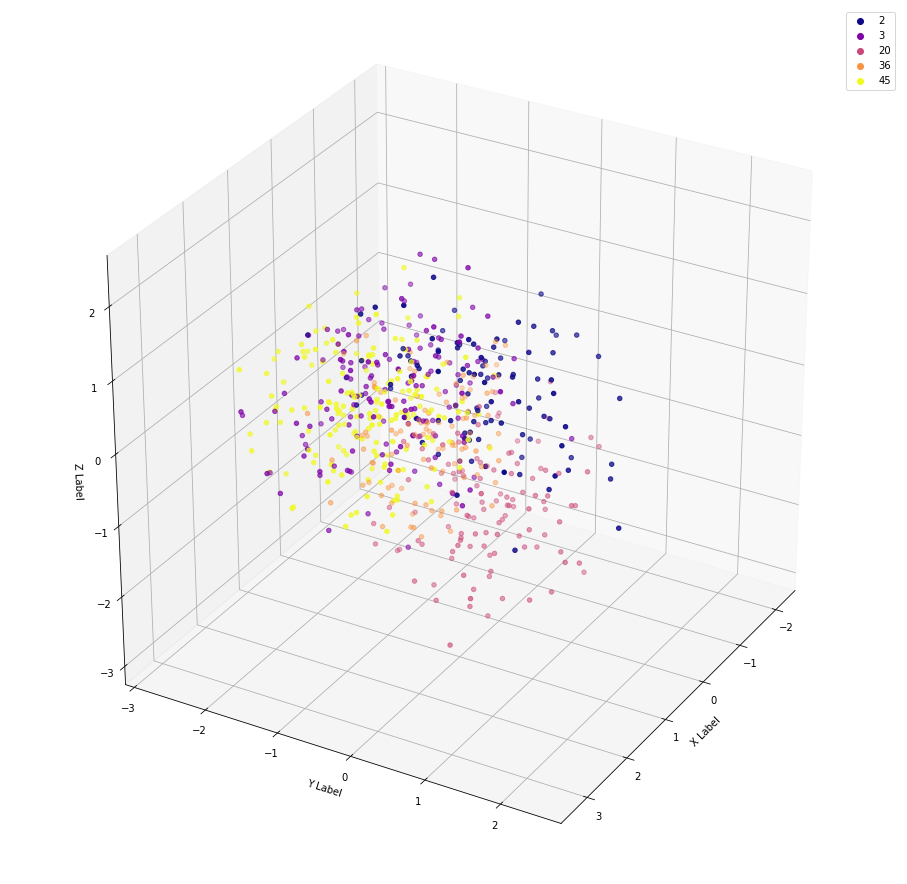

In [26]:
# 3D PC Plot

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(projection='3d')

colours_unique, colours_scaled = scatter_cmap(list(freq_analysis_df_filtered["Cluster"]))

scatter = ax.scatter(freq_analysis_df_filtered["PC1"],
           freq_analysis_df_filtered["PC2"],
           freq_analysis_df_filtered["PC3"],
           c=colours_scaled,
          cmap = "plasma")

handles, labels = scatter.legend_elements()
plt.legend(handles, colours_unique)

ax.view_init(30, 30)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

## Tweet-Level Analysis

### Average Embedding Vector Clustering

In [27]:
# Create an average embedding vector for each tweet
# Ignore stop words

tweet_sequences = tokenizer.texts_to_sequences(tweets_clean)
stop_words_tokens = tokenizer.texts_to_sequences([stop_words])[0]

tweet_embedding_avg_matrix = np.zeros((len(tweets_df), 100))
for i in range(len(tweets_df)):
    vector_sum = np.zeros(100)
    for token in tweet_sequences[i]:
        vector_sum += embedding_matrix[token - 2]
    tweet_embedding_avg_matrix[i] = vector_sum
tweet_embedding_avg_matrix = normalize(tweet_embedding_avg_matrix, axis=1)
tweets_df = pd.concat([tweets_df,
                                 pd.DataFrame(data=tweet_embedding_avg_matrix, columns=["ec"+str(i) for i in range(100)])],
                                 axis=1)

In [28]:
# Average embedding vector clustering (agglomerative)

num_clusters_tweets = 8
clustering_agg_tweets_avg = AgglomerativeClustering(n_clusters=None, distance_threshold=0.1,
                                                    linkage="complete", affinity="cosine").fit(tweet_embedding_avg_matrix)

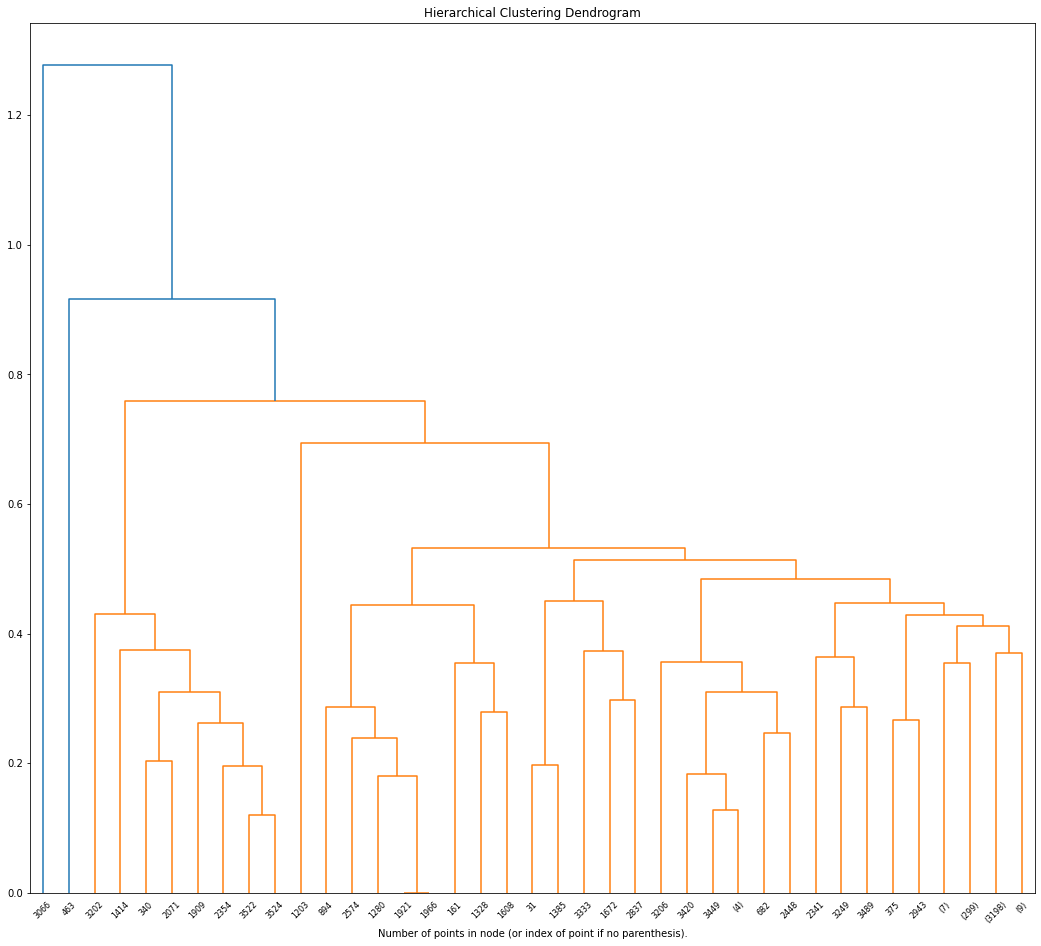

In [29]:
plot_dendrogram(clustering_agg_tweets_avg, truncate_mode="level", p=10)

In [30]:
# Average embedding vector clustering (kmeans)

num_clusters_tweets = 8
kmeans_tweets_avg = KMeans(n_clusters=num_clusters_tweets, random_state=0, n_init=10).fit(tweet_embedding_avg_matrix)
tweets_df["Cluster"] = kmeans_tweets_avg.labels_

### Cluster Exploration

In [31]:
# Display information about each cluster

for k in range(num_clusters_tweets):
    print("\nCluster: ",k)
    cluster_df = tweets_df[tweets_df["Cluster"]==k]
    print("Fraction of Data: ", len(cluster_df)/len(tweets_df))
    print("Average Likes: ", np.mean(cluster_df["Likes"]))
    for i in range(3):
        if i< len(cluster_df):
            print(cluster_df.sort_values(by="Likes", ascending=False).iloc[i,9])


Cluster:  0
Fraction of Data:  0.28161081385525205
Average Likes:  234.795
“You say you love your children above all else and yet, you're stealing their future in front of their very eyes.”

@gretathunberg calling out world leaders at #COP24. Let's hope they take her powerful message to heart before it's too late. https://t.co/pHtI0tmG1F
”You are not mature enough to tell it like it is. Even that burden you leave to your children.” 

Here’s my full speech in front of the UN plenary at #COP24 .
https://t.co/f0gxp0h3i2

#ClimateStrike #FridaysForFuture #SchoolStrike4Climate #ClimateJustice https://t.co/aDhqNrlSIp
”So we have not come here to beg the world leaders to care for our future. They have ignored us in the past and they will ignore us again.
We have come here to let them know that change is coming whether they like it or not.”

From my speech yesterday at #COP24 https://t.co/WIwv4vbT6G

Cluster:  1
Fraction of Data:  0.0205575894114334
Average Likes:  1.3013698630136987
Bicycle 

In [32]:
# Tweets from a specific cluster

list(tweets_df[tweets_df["Cluster"]==2].sort_values(by="Likes", ascending=False)["Content"].iloc[:50])

['"We\'re facing a man-made disaster of global scale... time is running out" - Sir David Attenborough issues warning at UN Climate Conference #COP24 in Poland https://t.co/I8q5wKRm3v https://t.co/e2GlRChign',
 'Delivering on the Paris Agreement requires action on #NaturalClimateSolutions alongside efforts on energy, industry, buildings, and transport. Nature is a critical part of the solution to avoiding the dangers of climate change. #COP24 @nature4climate https://t.co/eFg940hUnc',
 'World nations adopt a robust set of guidelines for implementing the landmark #ParisAgreement on #ClimateAction &gt; https://t.co/Jd4wbqXtV3  \n\nThe implementation of the agreement will benefit people from all walks of life, especially the most vulnerable.\n\n#GlobalGoals #COP24 https://t.co/vEdpNItY4o',
 'Thousands of people marching for climate in Katowice today. #cop24 https://t.co/wfx5kdOM70',
 "This Swedish 15-year-old inspired the student #climatestrike in cities around the world. She's now brought 

In [33]:
# Group tweets_df by category and cluster

tweets_cat_clust_df = pd.DataFrame(tweets_df["Date"].unique())
tweets_cat_clust_df = tweets_cat_clust_df.merge(pd.DataFrame(tweets_df["Category"].unique()), how="cross")
tweets_cat_clust_df = tweets_cat_clust_df.merge(pd.DataFrame(tweets_df["Cluster"].unique()), how="cross")
tweets_cat_clust_df = pd.DataFrame(np.array(tweets_cat_clust_df),
                                   columns = ["Date", "Category", "Cluster"])
tweets_cat_clust_df = tweets_cat_clust_df.merge(tweets_df.groupby(["Date", "Category", "Cluster"]).count().rename(columns={"ID":"Count"})["Count"],
                                                how="left", on=["Date", "Category", "Cluster"])
tweets_cat_clust_df = tweets_cat_clust_df.merge(tweets_df.groupby(["Date", "Category", "Cluster"]).sum()["Likes"],
                                                how="left", on=["Date", "Category", "Cluster"])
tweets_cat_clust_df.fillna(0,inplace=True)
tweets_cat_clust_df.sort_values(by = ["Date", "Category", "Cluster"], inplace=True)
tweets_cat_clust_df.reset_index(inplace=True)
tweets_cat_clust_df

,index,Date,Category,Cluster,Count,Likes
0,27,2018-11-15,Activist,0,0.0,0.0
1,30,2018-11-15,Activist,1,0.0,0.0
2,24,2018-11-15,Activist,2,0.0,0.0
3,31,2018-11-15,Activist,3,0.0,0.0
4,26,2018-11-15,Activist,4,0.0,0.0
...,...,...,...,...,...,...
3235,3207,2018-12-30,Scientist,3,0.0,0.0
3236,3202,2018-12-30,Scientist,4,0.0,0.0
3237,3205,2018-12-30,Scientist,5,0.0,0.0
3238,3201,2018-12-30,Scientist,6,0.0,0.0


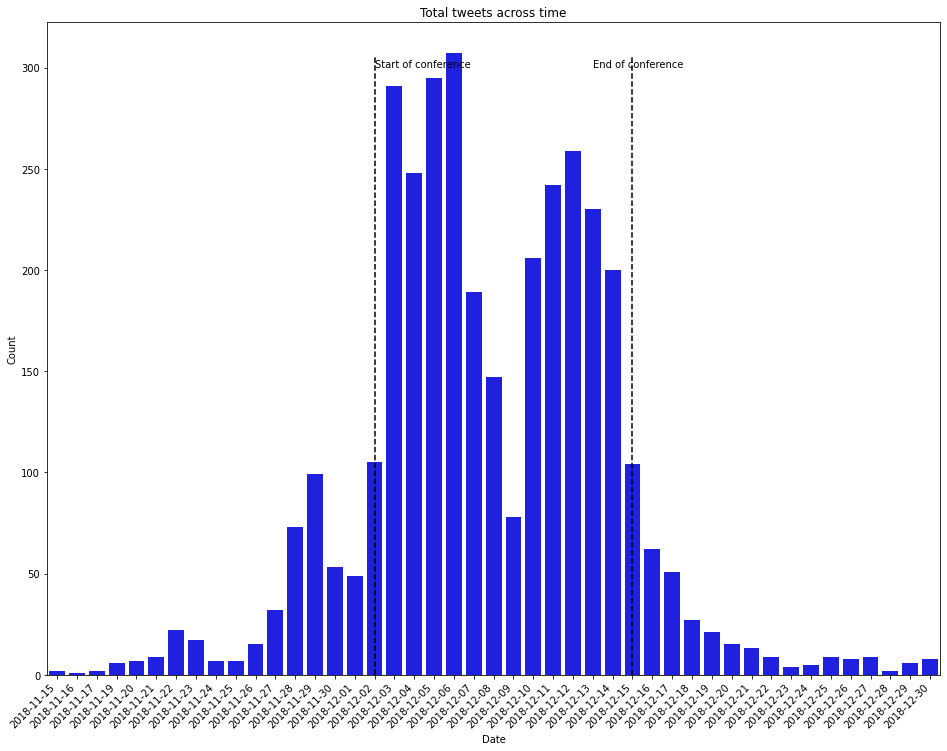

In [44]:
# Total tweet counts time series

plt.figure(figsize=(16,12))
bar = sns.barplot(data=tweets_cat_clust_df.groupby(["Date"]).sum().reset_index(), x="Date", y="Count", color="blue", ci=None)
bar.set_xticklabels(bar.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("Total tweets across time")
plt.axvline(16, 0, 0.95 , color="black", linestyle="--")
plt.axvline(29, 0, 0.95 , color="black", linestyle="--")
plt.text(16, 300, "Start of conference")
plt.text(27, 300, "End of conference")
plt.show()

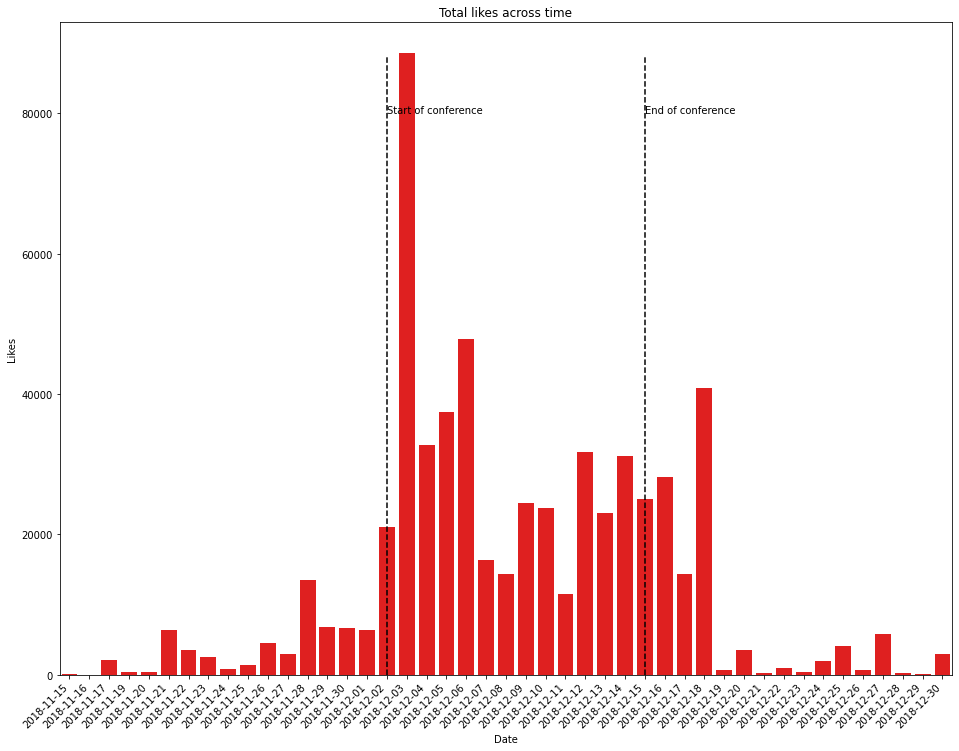

In [45]:
# Total tweet likes time series

plt.figure(figsize=(16,12))
bar = sns.barplot(data=tweets_cat_clust_df.groupby(["Date"]).sum().reset_index(), x="Date", y="Likes", color="red", ci=None, )
bar.set_xticklabels(bar.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("Total likes across time")
plt.axvline(16, 0, 0.95 , color="black", linestyle="--")
plt.axvline(29, 0, 0.95 , color="black", linestyle="--")
plt.text(16, 80000, "Start of conference")
plt.text(29, 80000, "End of conference")
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1296x1152 with 0 Axes>

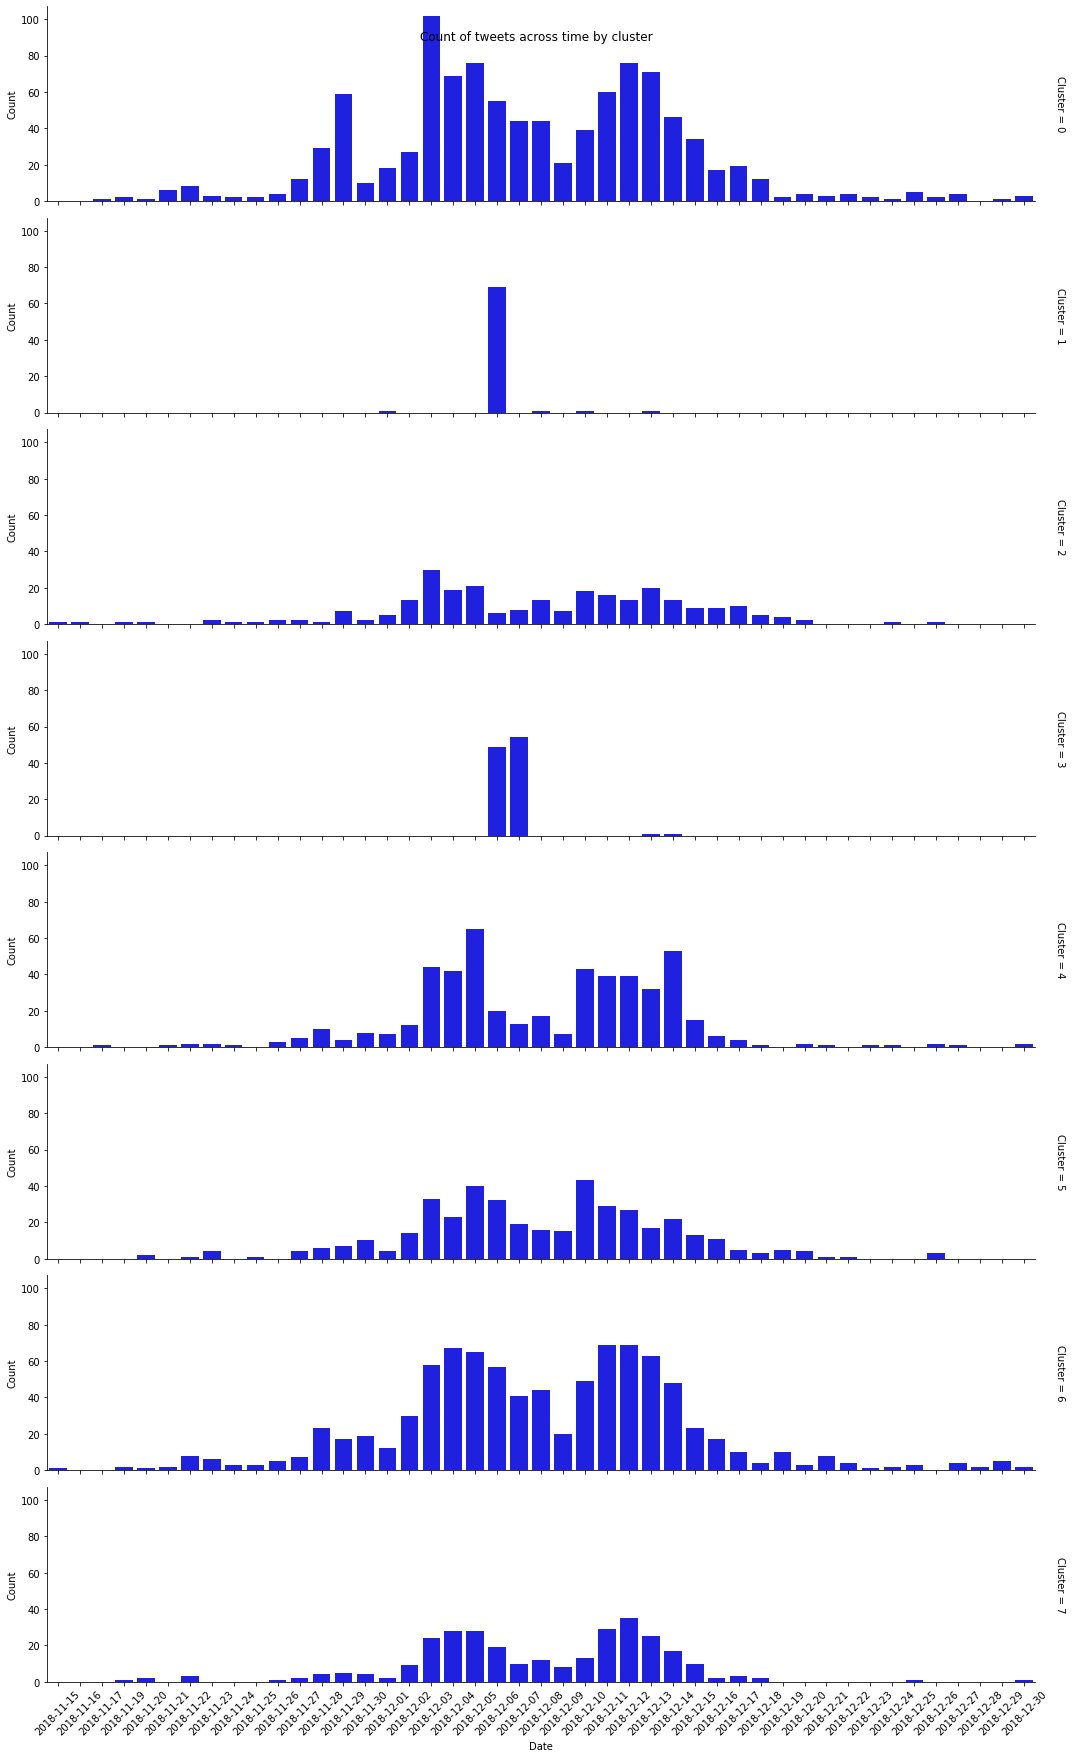

In [36]:
# Count of Tweets Across Time by Cluster

plt.figure(figsize=(18,16))
g = sns.FacetGrid(tweets_cat_clust_df.groupby(["Date","Cluster"]).sum().reset_index(),
                  row="Cluster", aspect=5, margin_titles=True, sharey=True)
g.map(sns.barplot, "Date", "Count", ci=None, color="blue")
g.fig.suptitle("Count of tweets across time by cluster")
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1296x1152 with 0 Axes>

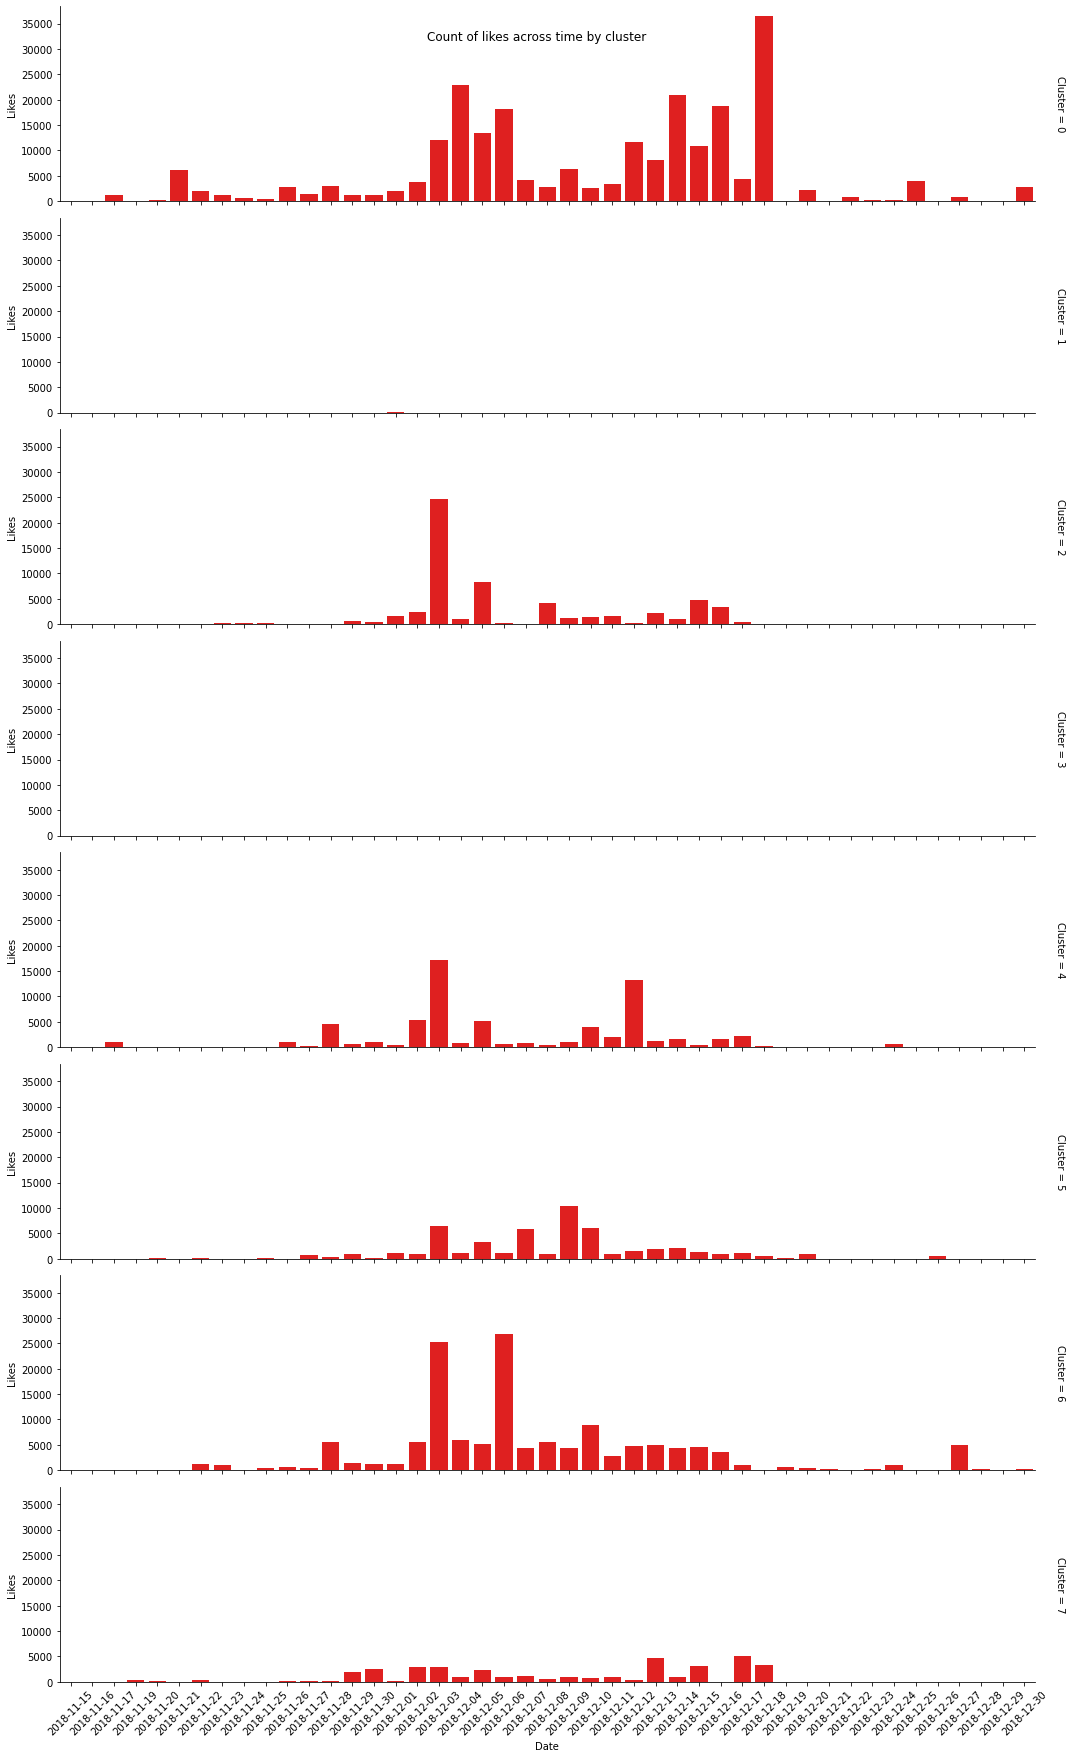

In [37]:
# Tweet Likes Across Time by Cluster

plt.figure(figsize=(18,16))
g = sns.FacetGrid(tweets_cat_clust_df.groupby(["Date","Cluster"]).sum().reset_index(),
                  row="Cluster", aspect=5, margin_titles=True, sharey=True)
g.map(sns.barplot, "Date", "Likes", ci=None, color="red")
g.fig.suptitle("Count of likes across time by cluster")
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1296x1152 with 0 Axes>

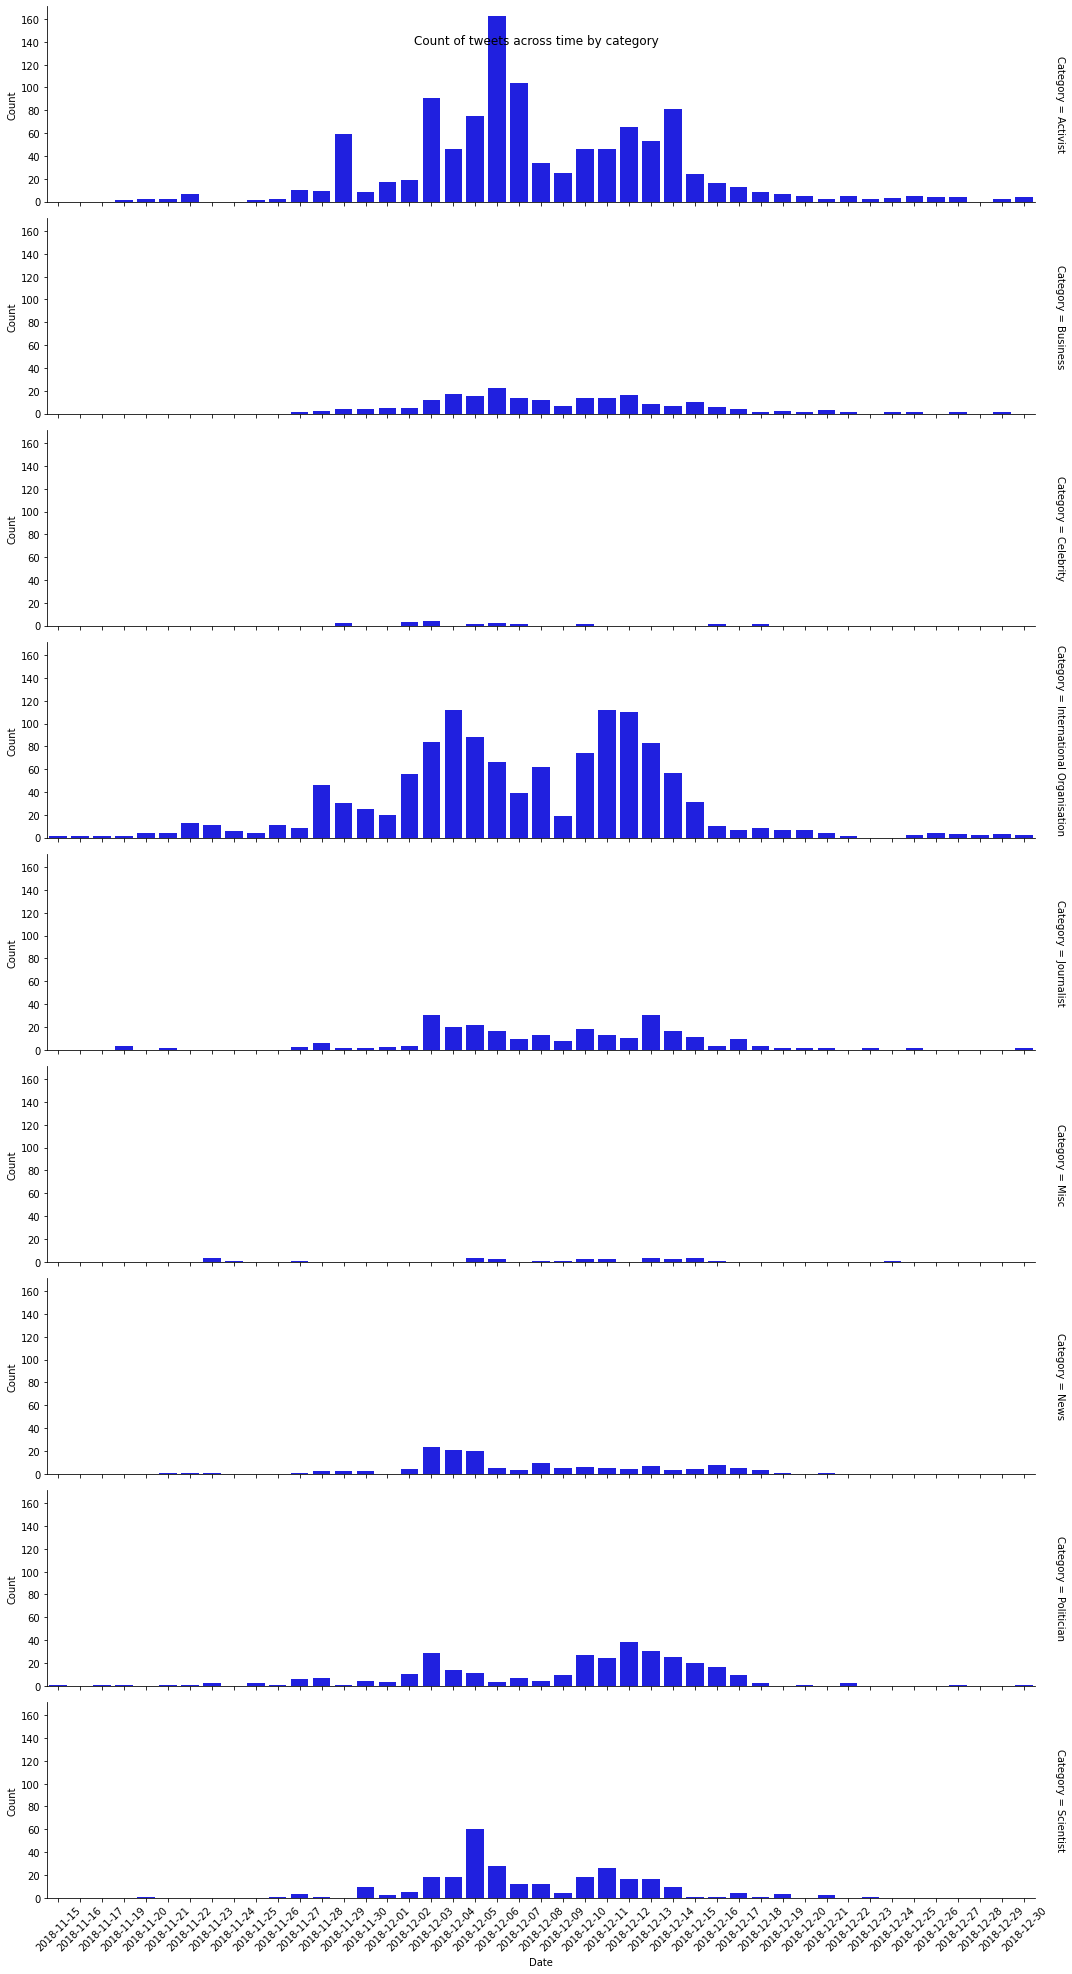

In [38]:
# Tweet Counts Across Time by Category

plt.figure(figsize=(18,16))
g = sns.FacetGrid(tweets_cat_clust_df.groupby(["Date","Category"]).sum().reset_index(), row="Category", aspect=5, margin_titles=True, sharey=True)
g.map(sns.barplot, "Date", "Count", ci=None, color="blue")
g.fig.suptitle("Count of tweets across time by category")
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1296x1152 with 0 Axes>

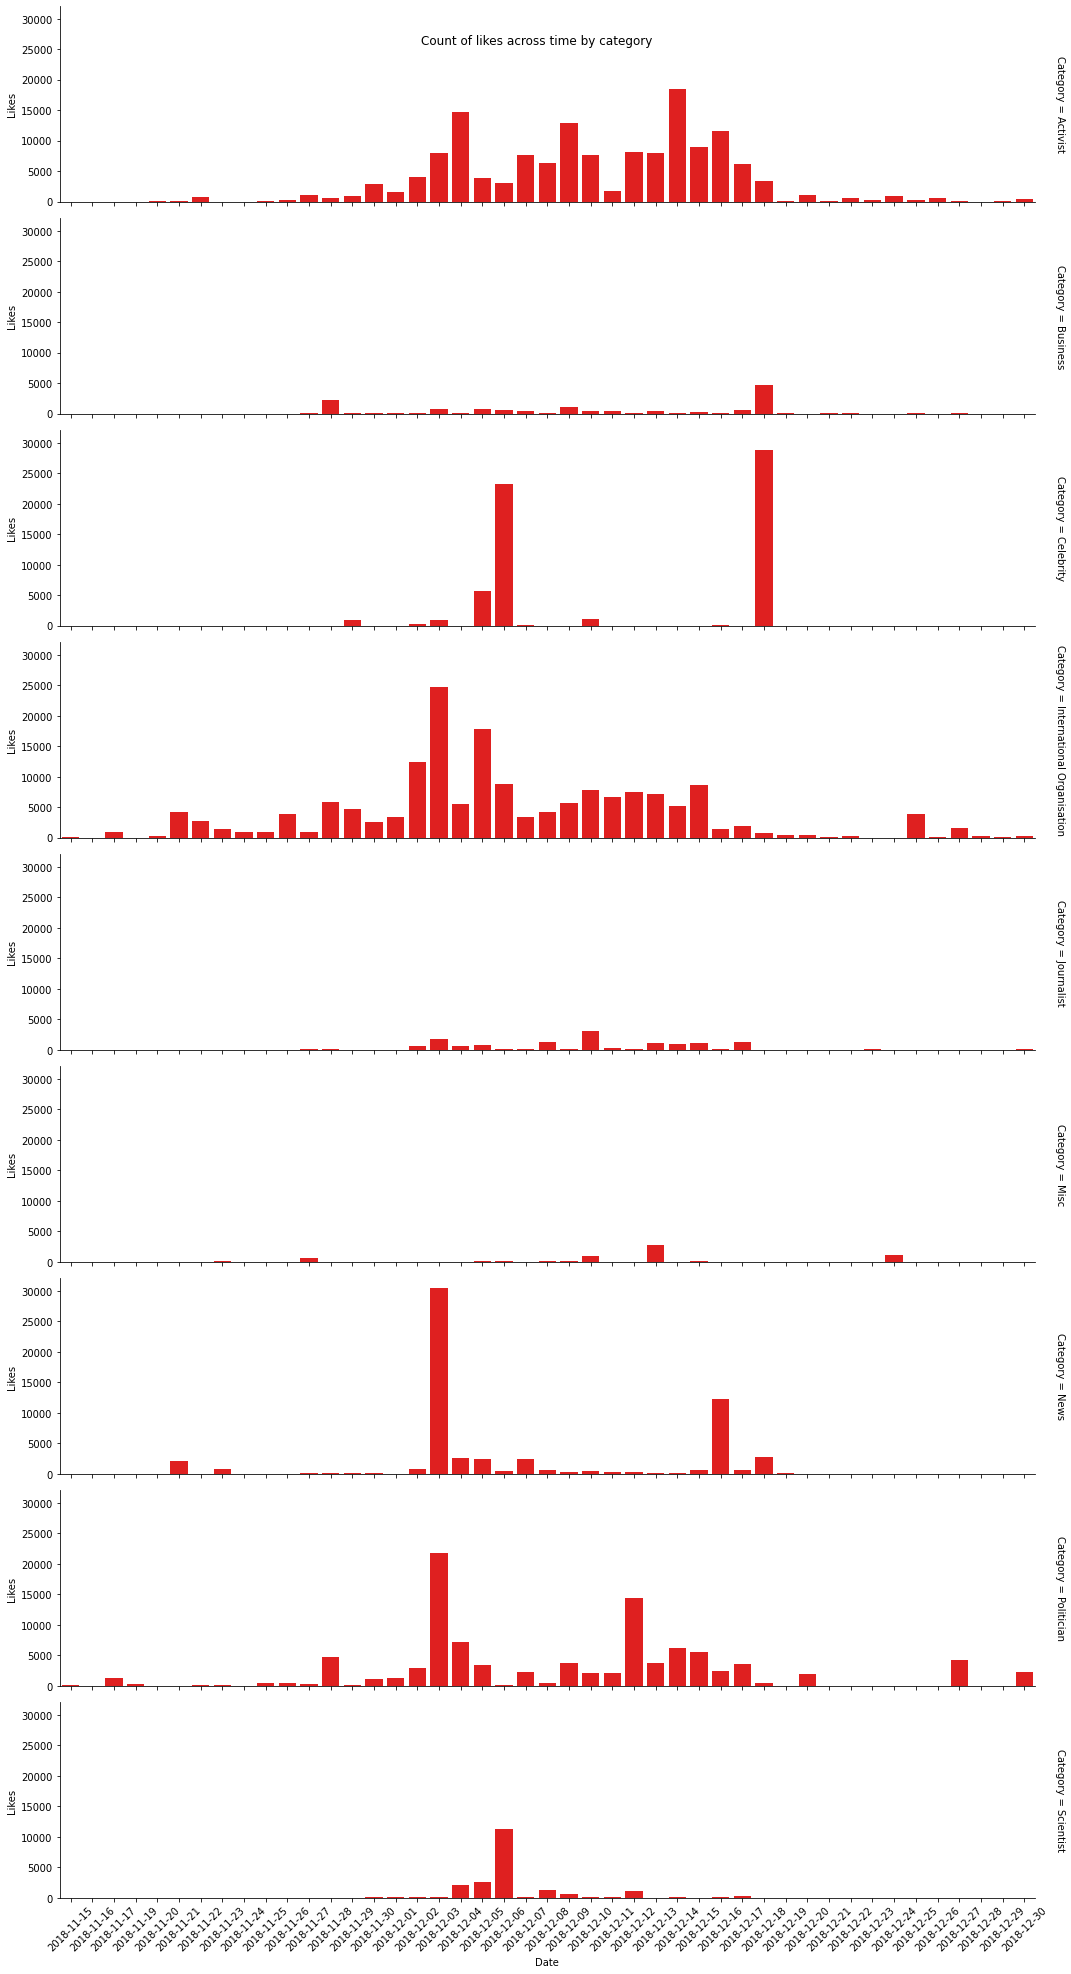

In [39]:
# Tweet Likes Across Time by Category

plt.figure(figsize=(18,16))
g = sns.FacetGrid(tweets_cat_clust_df.groupby(["Date","Category"]).sum().reset_index(), row="Category", aspect=5, margin_titles=True, sharey=True)
g.map(sns.barplot, "Date", "Likes", ci=None, color="red")
g.fig.suptitle("Count of likes across time by category")
plt.xticks(rotation=45)
plt.show()

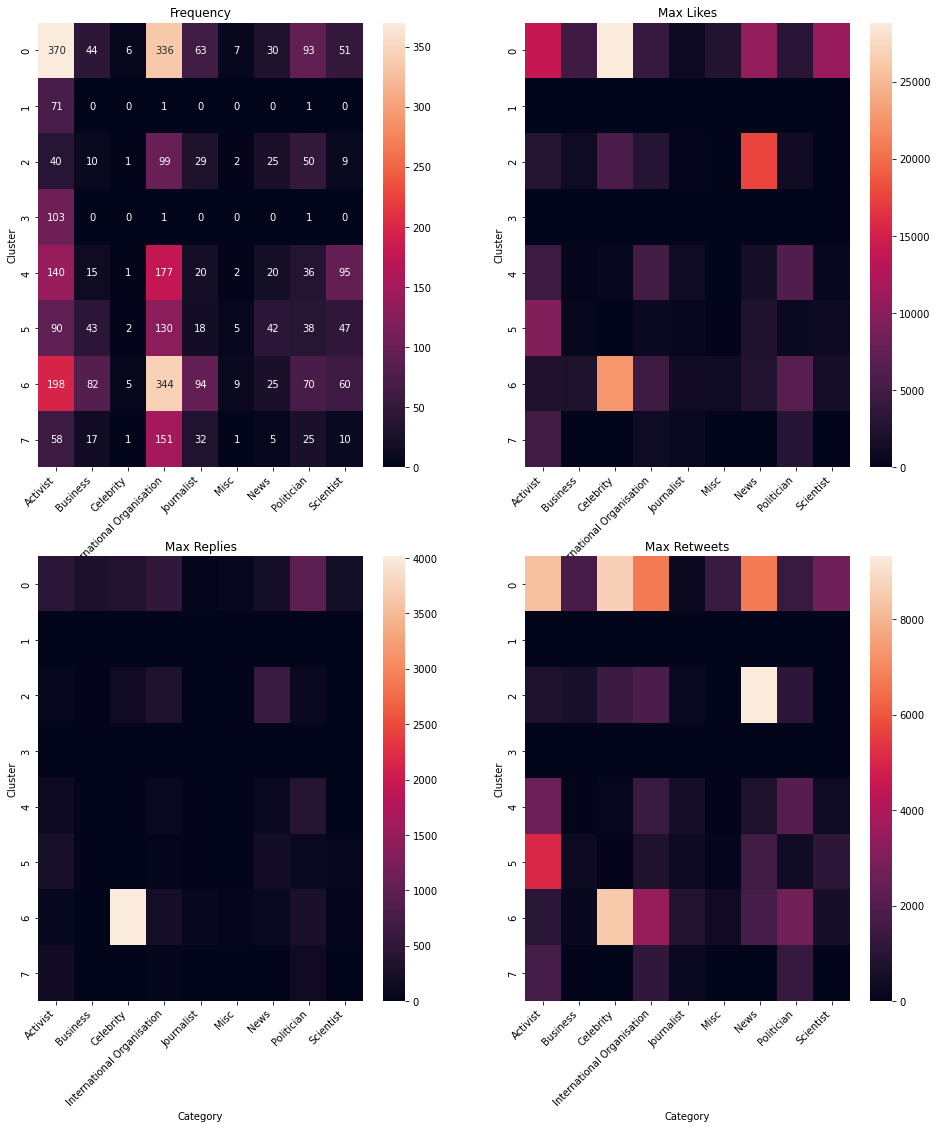

In [40]:
# Cluster-Category co-occurence matrices

plt.figure(figsize=(16,18))

plt.subplot(221)
plt.title("Frequency")
heat = sns.heatmap(tweets_df.pivot_table(values="ID",index="Cluster",columns="Category",aggfunc="count").fillna(0.0), annot=True, fmt="g")
heat.set_xticklabels(heat.get_xticklabels(), rotation=45, horizontalalignment='right')

for i, val in enumerate(["Likes","Replies","Retweets"]):
    plt.subplot(222+i)
    plt.title("Max "+val)
    heat = sns.heatmap(tweets_df.pivot_table(values=val,index="Cluster",columns="Category",aggfunc="max").fillna(0.0))
    heat.set_xticklabels(heat.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

<Figure size 1296x1152 with 0 Axes>

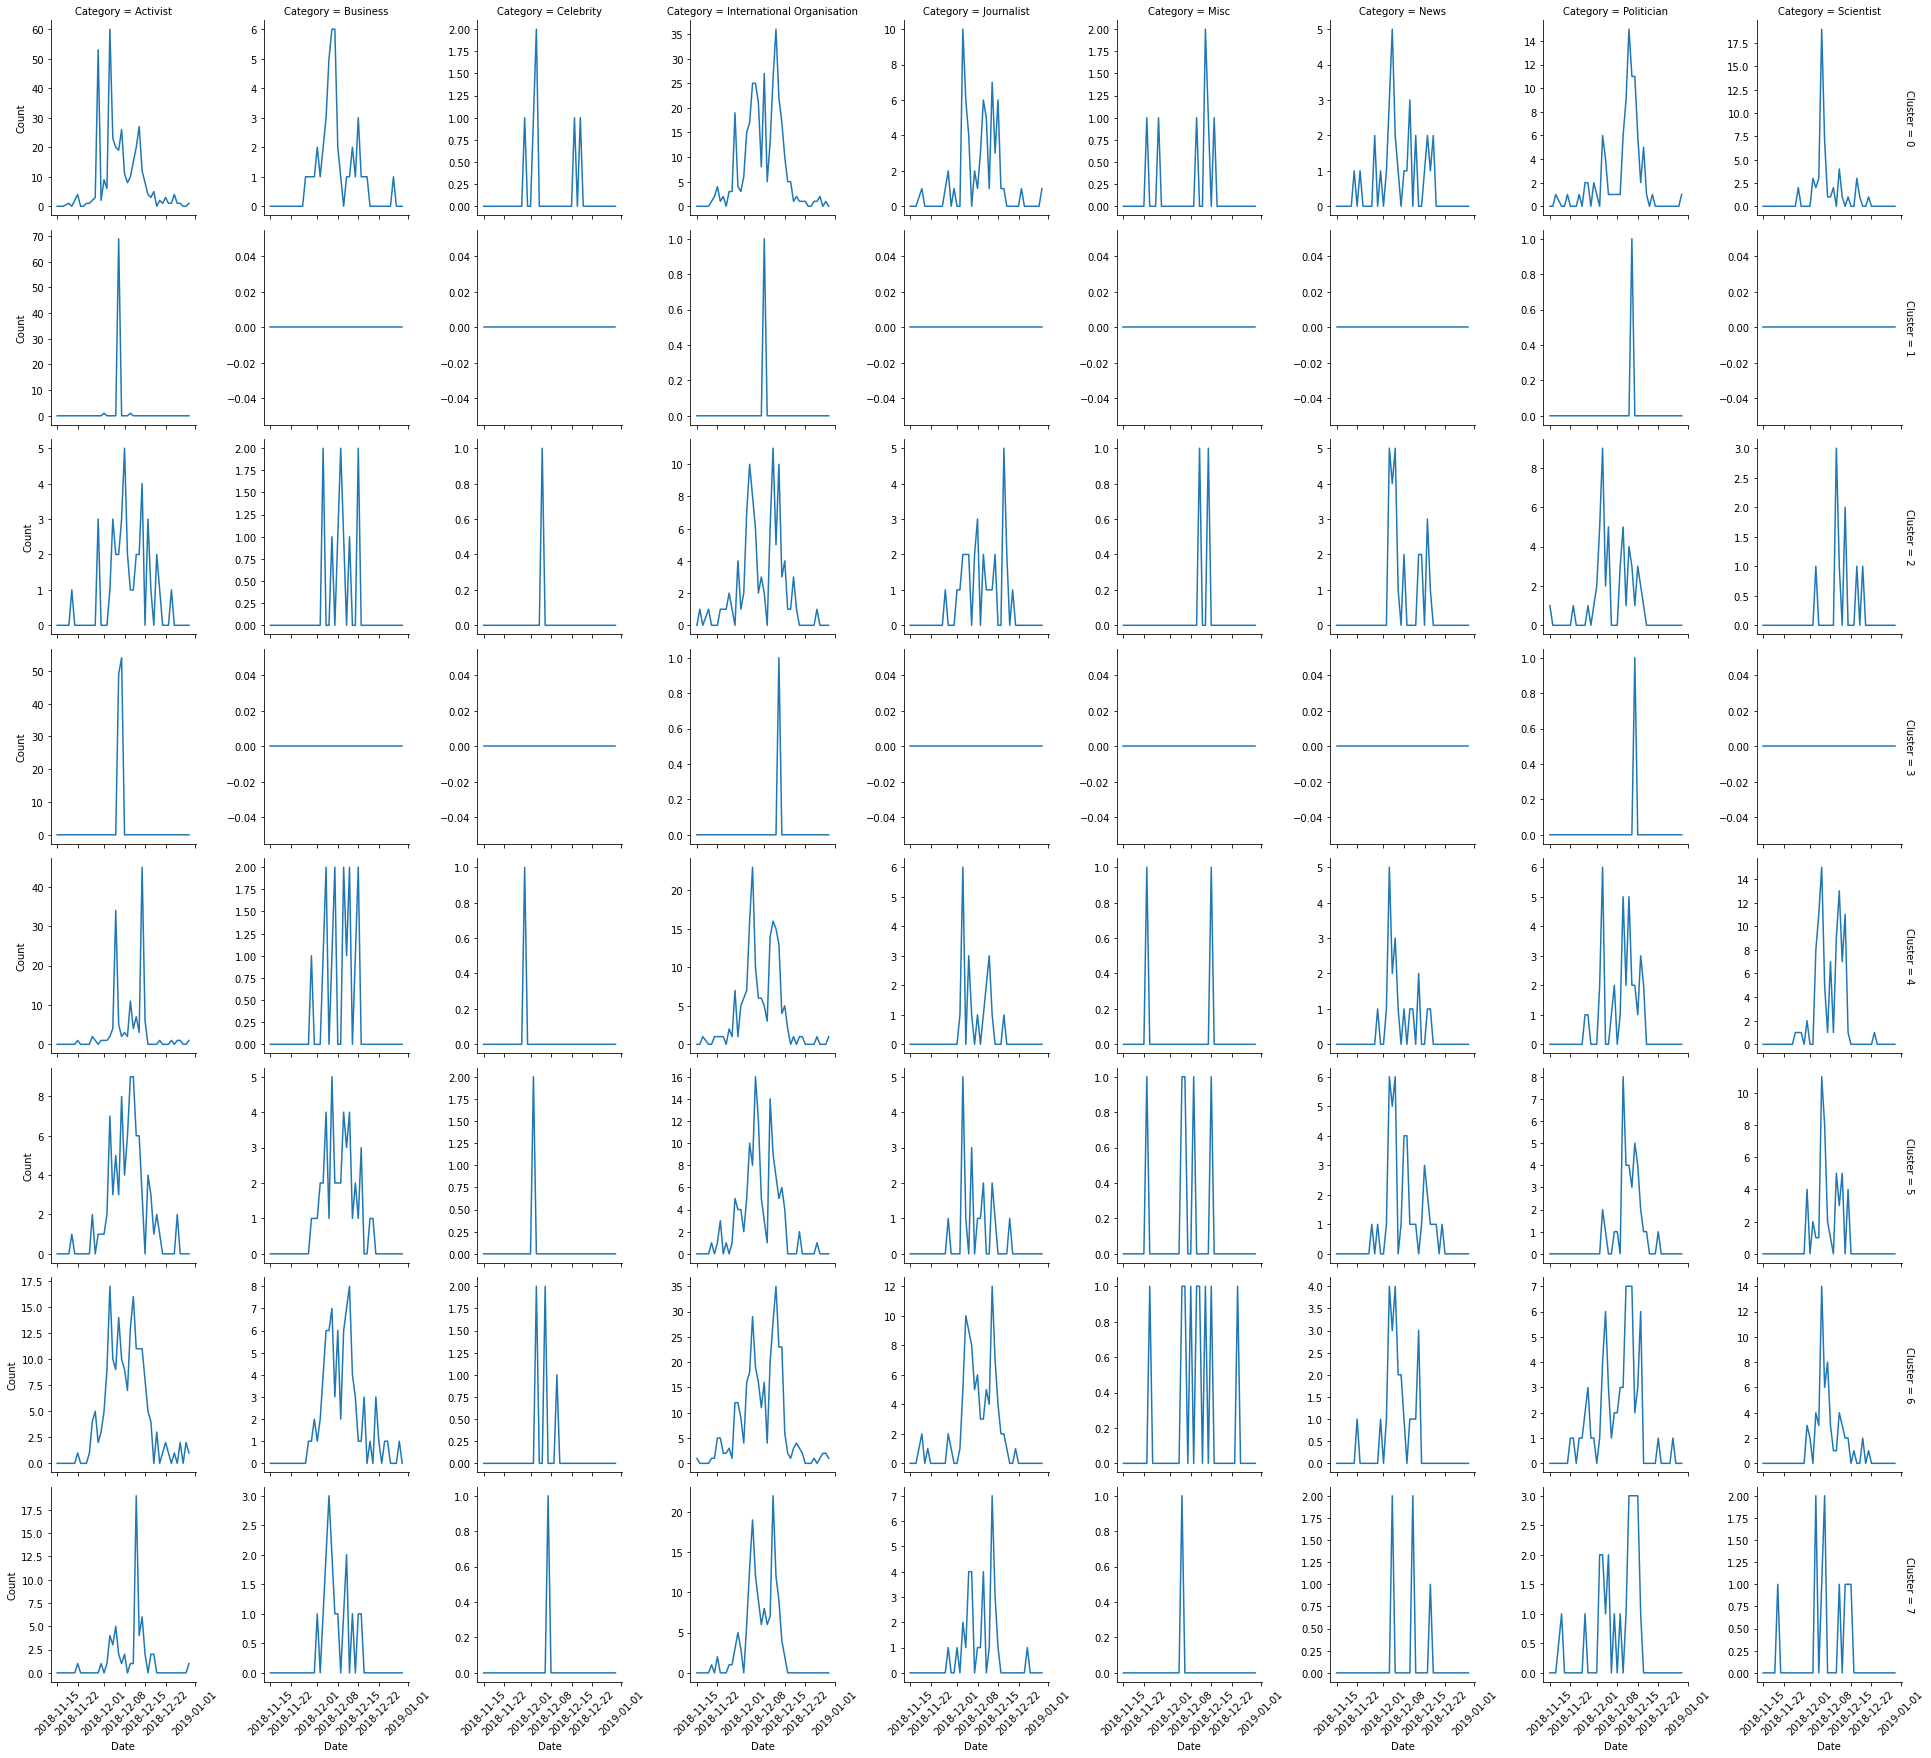

In [41]:
# Timeseries of Counts of Tweets by Cluster and Category

plt.figure(figsize=(18,16))
g = sns.FacetGrid(tweets_cat_clust_df, row = "Cluster", col="Category", margin_titles=True, sharey=False)
g.map(sns.lineplot, "Date", "Count", err_style=None)
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
plt.show()

In [42]:
# PCA

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
tweet_embedding_avg_matrix_pc = pca.fit_transform(tweet_embedding_avg_matrix)
tweets_df["PC1"] = tweet_embedding_avg_matrix_pc[:,0]
tweets_df["PC2"] = tweet_embedding_avg_matrix_pc[:,1]
tweets_df["PC3"] = tweet_embedding_avg_matrix_pc[:,2]

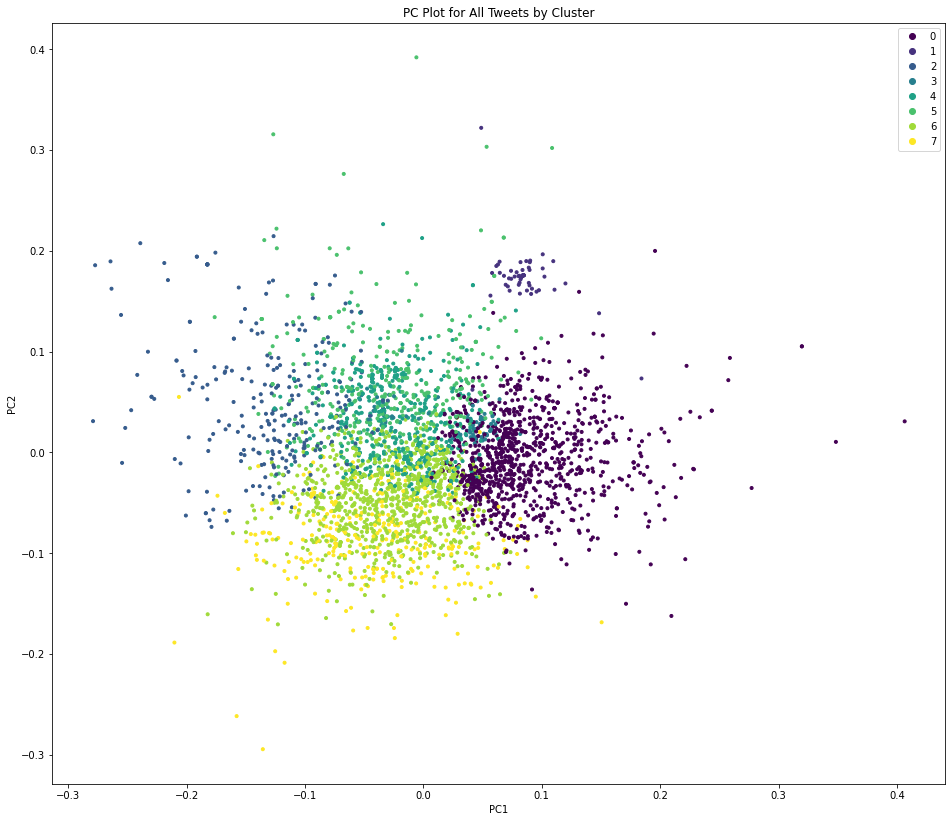

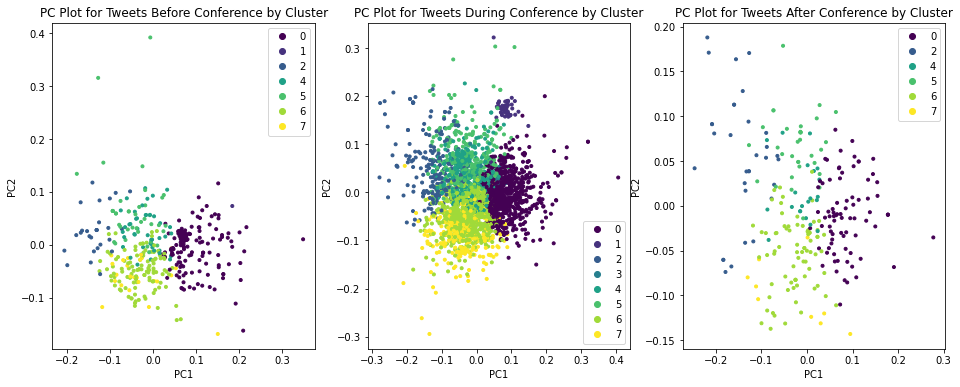

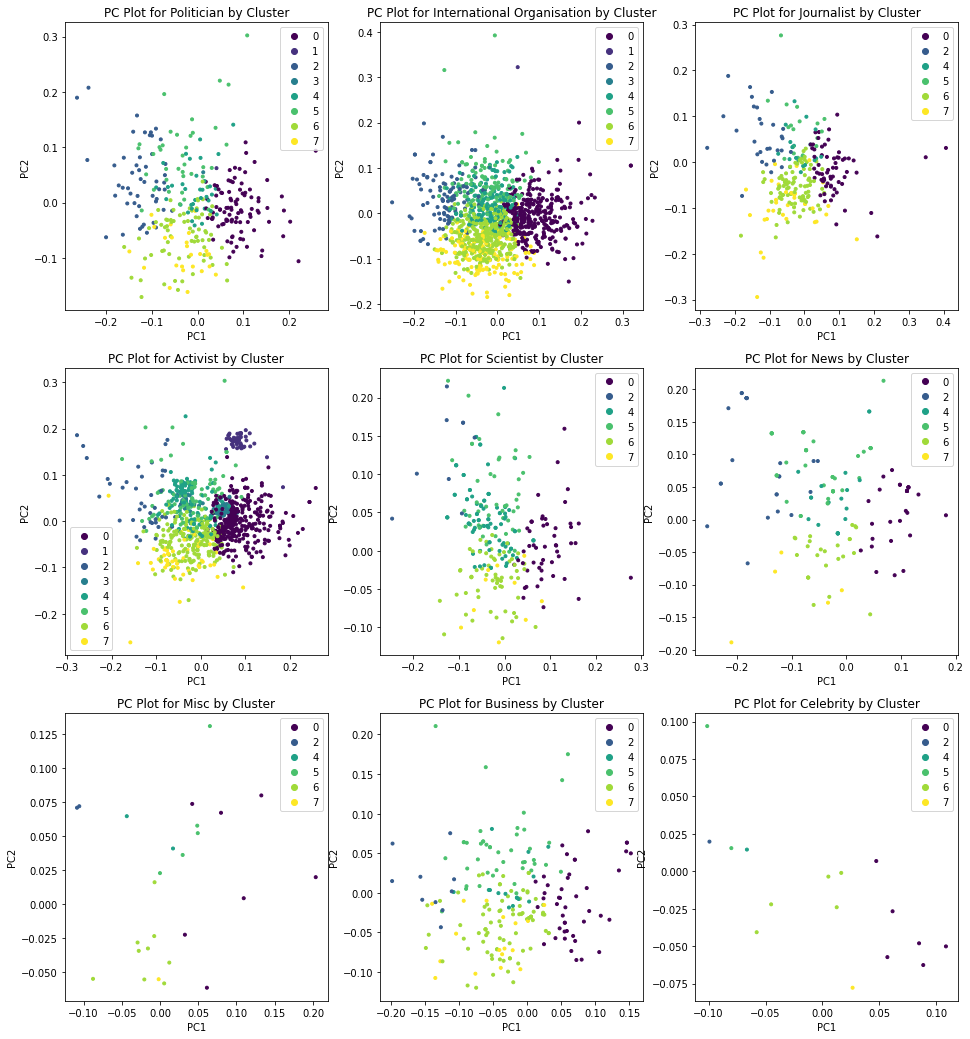

In [43]:
# PC Plots

# Organise colours
colours_unique_all, colours_scaled_all = scatter_cmap(list(tweets_df["Cluster"]))
tweets_df["colours_scaled"] = colours_scaled_all
tweets_df["period"] = tweets_df["Date"].apply(lambda x: (x >= dt.datetime.strptime("2018-12-02","%Y-%m-%d").date()) + (x > dt.datetime.strptime("2018-12-15","%Y-%m-%d").date()))

# All-time plot

plt.figure(figsize=(16,14))

scatter = plt.scatter(tweets_df["PC1"],
                      tweets_df["PC2"],
                      c=colours_scaled_all,
                      cmap = "viridis",
                      marker='.')
handles, labels = scatter.legend_elements()
plt.legend(handles, colours_unique_all)
plt.title("PC Plot for All Tweets by Cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()

# Plots for each period

plt.figure(figsize=(16,6))

for i, p in enumerate(["Before","During","After"]):
    plt.subplot(131+i)
    tweets_df_filtered = tweets_df[tweets_df["period"] == i]
    colours_scaled = list(tweets_df_filtered["colours_scaled"])
    colours_unique = list(set(list(tweets_df_filtered["Cluster"])))
    scatter = plt.scatter(tweets_df_filtered["PC1"],
                tweets_df_filtered["PC2"],
                c=colours_scaled,
                cmap = "viridis",
                marker='.')
    handles, labels = scatter.legend_elements()
    plt.legend(handles, colours_unique)
    plt.title("PC Plot for Tweets "+p+" Conference by Cluster")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

plt.show()

# Plots for each category

categories = list(tweets_df["Category"].unique())

plt.figure(figsize=(16,18))

for i, cat in enumerate(categories):
    plt.subplot(331+i)
    tweets_df_filtered = tweets_df[tweets_df["Category"] == cat]
    colours_scaled = list(tweets_df_filtered["colours_scaled"])
    colours_unique = list(set(list(tweets_df_filtered["Cluster"])))
    scatter = plt.scatter(tweets_df_filtered["PC1"],
                tweets_df_filtered["PC2"],
                c=colours_scaled,
                cmap = "viridis",
                marker='.')
    handles, labels = scatter.legend_elements()
    plt.legend(handles, colours_unique)
    plt.title("PC Plot for "+cat+" by Cluster")
    plt.xlabel("PC1")
    plt.ylabel("PC2")